Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Paul de Graaf"
COLLABORATORS = "Luc de Vries"

---

# Python assignment

The python assignment you can do either on your own or with one other student (i.e. max group size is 2 students).

The first cell of your notebook, should contain a table with the names and SNRs and ANRs of the group members, like so

|Name|SNR|ANR|
|----|---|----|
|Paul de Graaf|2026405|u663408|
|Luc de Vries|2024422|u940400|



See [the webpage](https://janboone.github.io/applied-economics/#org065a005) for details of what we expect to see in this assignment.



# Research question (0.5 points)

What is best method to achieve the goals of the Common agricultural policy?

# Motivation (0.5 points)

Motivate why this question is interesting.

# Method (0.5 points)


# Preview of the answers (0.5 points)

Summarize the results that you find and the answer to your research question.

# Main assumptions (0.5 points)

What are the main assumptions that you need to answer the question? If you do a theory notebook, what are the main assumptions of your model? If you use data, what assumptions are needed by your estimation method.

# Python code (6.5 points)


Give the python code in code cells and use markdown cells to explain why you code things in this way and what the outcomes are of the code cells.

Note that the explanation of your code is at least as important as the python code itself.

Create as many python and markdown cells as you need to explain things well.


In [46]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.patches as pl
import seaborn as sns
from scipy import stats, optimize
import random

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sn
from scipy import optimize
import pymc3 as pm
import statsmodels.api as sm # check the error that cannot import name 'factorial' in from scipy.misc import factorial
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import arviz as az

import theano
import covid19pandas as cod
from country_codes import eurostat_dictionary
import eurostat
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
plt.style.use('seaborn')
%matplotlib inline


In [47]:
EU_countries = ['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
'Germany (until 1990 former territory of the FRG)', 'Germany','Estonia',
'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom',
'Iceland', 'Liechtenstein', 'Norway', 'Switzerland',
'Bosnia and Herzegovina']

In [48]:
lifesat = eurostat.get_data_df('ilc_pw01') # average rating of satisfaction
realgdppc = eurostat.get_data_df('sdg_08_10') # Real gdp per capita
emissionpc = eurostat.get_data_df('t2020_rd300') # greenhouse gas emissions per capita 
socialprotpc = eurostat.get_data_df('tps00100') # social protection expenditure per inhabitant

In [49]:
lifesat.rename({'geo\\time':'geo'},inplace=True,axis=1) # rename geo\time to geo, makes handling the data easier
lifesat = lifesat.groupby(by="geo").mean() # group per country as this is the data that we will use

In [50]:
lifesat = lifesat.reset_index() # reset the index to make sure that the melt function can read the geo columnname correctly
lifesat = lifesat.melt(id_vars= ["geo"],value_vars=np.arange(2013,2019,5),
                        var_name='year',value_name='life satisfaction')# set the values for each years in rows, this allows to combine multiple tables later
                    
lifesat

,geo,year,life satisfaction
0,AL,2013,NaN
1,AT,2013,7.970049
2,BE,2013,7.512500
3,BG,2013,5.433099
4,CH,2013,7.986221
...,...,...,...
83,SI,2018,7.494833
84,SK,2018,7.043855
85,TR,2018,6.043941
86,UK,2018,7.511765


In [51]:
realgdppc.rename({'geo\\time':'geo'},inplace=True,axis=1)
realgdppc = realgdppc[(realgdppc.unit == 'CLV10_EUR_HAB')]
realgdppc = realgdppc.reset_index()
realgdppc= realgdppc.melt(id_vars= ["geo"],value_vars=np.arange(2012,2022),
                        var_name='year',value_name='Real GDP per capita')
realgdppc

,geo,year,Real GDP per capita
0,AL,2012,3230.0
1,AT,2012,36390.0
2,BE,2012,33490.0
3,BG,2012,5390.0
4,CH,2012,58820.0
...,...,...,...
385,SE,2021,44340.0
386,SI,2021,21260.0
387,SK,2021,15660.0
388,TR,2021,NaN


In [52]:
emissionpc.rename({'geo\\time':'geo'},inplace=True,axis=1)
emissionpc = emissionpc.reset_index()
emissionpc = emissionpc.melt(id_vars= ["geo"],value_vars=np.arange(2012,2020),
                        var_name='year',value_name='Emissions')

emissionpc

,geo,year,Emissions
0,AT,2012,9.7
1,BE,2012,11.2
2,BG,2012,8.3
3,CH,2012,7.1
4,CY,2012,11.0
...,...,...,...
267,SE,2019,5.2
268,SI,2019,8.2
269,SK,2019,7.4
270,TR,2019,6.3


In [53]:
socialprotpc.rename({'geo\\time':'geo'},inplace=True,axis=1)
socialprotpc = socialprotpc.reset_index()
socialprotpc = socialprotpc.melt(id_vars= ["geo"],value_vars=np.arange(2012,2020),
                        var_name='year',value_name='Social security')

socialprotpc

,geo,year,Social security
0,AT,2012,10125.68
1,BA,2012,NaN
2,BE,2012,9257.45
3,BG,2012,2117.19
4,CH,2012,10770.67
...,...,...,...
323,SE,2019,10276.33
324,SI,2019,6095.87
325,SK,2019,4252.34
326,TR,2019,2692.80


In [54]:
healthcare = eurostat.get_data_df('tespm110') # unmet needs for medical care
educ = eurostat.get_data_df('sdg_04_10') # early leavers from education
jobsecurity = eurostat.get_data_df('ilc_lvhl30') # labour transitions by employment status
crime = eurostat.get_data_df('ilc_mddw03') # crime/violence/vandalism in the area
paygap = eurostat.get_data_df('tesem180') # gender pay gab in unadjusted form

In [55]:
healthcare.rename({'geo\\time':'geo'},inplace=True,axis=1)
healthcare = healthcare.reset_index()
healthcare  = healthcare [(healthcare.sex == 'T')] # only use the total and not individual sexes
healthcare= healthcare.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='Healthcare')
healthcare

,geo,year,Healthcare
0,AL,2012,NaN
1,AT,2012,0.3
2,BE,2012,1.7
3,BG,2012,8.3
4,CH,2012,1.0
...,...,...,...
364,SE,2020,1.5
365,SI,2020,2.7
366,SK,2020,3.2
367,TR,2020,1.9


In [56]:
educ.rename({'geo\\time':'geo'},inplace=True,axis=1)
educ = educ.reset_index()
educ = educ [(educ.sex == 'T')] # only use the total and not individual sexes
educ= educ.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='educ')
educ

,geo,year,educ
0,AT,2012,7.8
1,BE,2012,12.0
2,BG,2012,12.5
3,CH,2012,5.5
4,CY,2012,11.4
...,...,...,...
337,SE,2020,7.7
338,SI,2020,4.1
339,SK,2020,7.6
340,TR,2020,26.7


In [57]:
jobsecurity.rename({'geo\\time':'geo'},inplace=True,axis=1)
jobsecurity = jobsecurity.reset_index()
jobsecurity = jobsecurity [(jobsecurity.sex == 'T')&(jobsecurity.trans1y == 'TO_UNE')&(jobsecurity.wstatus.isin([ 'EMP_PT',"EMP","EMP_FT"]))]# only use the total and not individual sexes and people that get employed a year later when they are employed
jobsecurity= jobsecurity.reset_index()
jobsecurity= jobsecurity.melt(id_vars= ["geo","trans1y", "wstatus"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='jobsecurity')
jobsecurity = jobsecurity.groupby(by=["geo","year"]).mean()
jobsecurity= jobsecurity.reset_index()
jobsecurity


,geo,year,jobsecurity
0,AL,2012,NaN
1,AL,2013,NaN
2,AL,2014,NaN
3,AL,2015,NaN
4,AL,2016,NaN
...,...,...,...
382,UK,2016,1.600000
383,UK,2017,1.233333
384,UK,2018,1.300000
385,UK,2019,NaN


In [58]:
crime.rename({'geo\\time':'geo'},inplace=True,axis=1)
crime = crime.reset_index()
crime = crime [(crime.incgrp == 'TOTAL')& (crime.hhtyp == "TOTAL")] # only use the total and not individual sexes
crime= crime.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='crime')
crime

,geo,year,crime
0,AL,2012,NaN
1,AT,2012,11.7
2,BE,2012,14.5
3,BG,2012,26.9
4,CH,2012,16.5
...,...,...,...
391,SI,2020,7.3
392,SK,2020,4.3
393,TR,2020,9.8
394,UK,2020,NaN


In [59]:
paygap.rename({'geo\\time':'geo'},inplace=True,axis=1)
paygap = paygap.reset_index()
paygap= paygap.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='paygap in %')
paygap

,geo,year,paygap in %
0,AL,2012,NaN
1,AT,2012,22.9
2,BE,2012,8.3
3,BG,2012,15.1
4,CH,2012,17.4
...,...,...,...
346,SE,2020,11.2
347,SI,2020,3.1
348,SK,2020,15.8
349,TR,2020,NaN


In [70]:
df1=lifesat.merge(crime,how='left',left_on=['geo','year'], right_on=['geo','year'])
df2=df1.merge(realgdppc,how='left',left_on=['geo','year'], right_on=['geo','year'])
df3=df2.merge(emissionpc,how='left',left_on=['geo','year'], right_on=['geo','year'])
df4=df3.merge(socialprotpc,how='left',left_on=['geo','year'], right_on=['geo','year'])
df5=df4.merge(healthcare,how='left',left_on=['geo','year'], right_on=['geo','year'])
df6=df5.merge(educ,how='left',left_on=['geo','year'], right_on=['geo','year'])
df7=df6.merge(jobsecurity,how='left',left_on=['geo','year'], right_on=['geo','year'])
df=df7.merge(paygap,how='left',left_on=['geo','year'], right_on=['geo','year'])
df.head()


df9 = df[df.year == 2013]
df10 = df[df.year == 2018]
df = pd.concat([df9,df10])
meanlifsat = df['life satisfaction'].mean()
stdlifsat = df['life satisfaction'].std()

df_x = df[['life satisfaction','crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]]
df[['life satisfaction','crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]] = (df_x-df_x.mean())/df_x.std() ## standerdize variables
df = df.rename(columns={'Real GDP per capita': 'Gdp', 'Social security': 'Socsec', 'paygap in %': 'paygap', 'life satisfaction': 'Lifesat'})
df = df[['Lifesat','crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]]

def fillNaN_with_unifrand(df):
    a = df.values
    m = pd.isna(a) # mask of NaNs
    mu, sigma = 0, 1
    a[m] = np.random.normal(mu, sigma, size=m.sum())
    return df

df= fillNaN_with_unifrand(df)





In [116]:
train = df[:65]
test= df[65:89]
train
test

trainy = train['Lifesat'].values
trainX = train[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]].values

testy = test['Lifesat'].values
testX = test[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]].values


In [139]:
model = keras.Sequential([
    keras.layers.Dense(100, input_dim = 8, activation='relu'), # input layer
    keras.layers.Dense(100, activation = 'relu'),                   # hidden
    keras.layers.Dense(11, activation = 'softmax')             # output 11 is not included so chooses between 1 and 10
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [140]:
history = model.fit(trainX,trainy,epochs=20,validation_data=(testX, testy))

Epoch 1/20
3/3 [==============================] - 1s 135ms/step - loss: 2.4149 - accuracy: 0.0000e+00 - val_loss: 2.2361 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 0s 43ms/step - loss: 2.2142 - accuracy: 0.0000e+00 - val_loss: 2.0561 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 2.0929 - accuracy: 0.0000e+ - 0s 53ms/step - loss: 2.0728 - accuracy: 0.0000e+00 - val_loss: 1.8889 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 0s 49ms/step - loss: 1.9424 - accuracy: 0.0000e+00 - val_loss: 1.7378 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 0s 53ms/step - loss: 1.8153 - accuracy: 0.0000e+00 - val_loss: 1.5990 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 0s 43ms/step - loss: 1.6949 - accuracy: 0.0000e+00 - val_loss: 1.4697 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 0s 10ms/step - loss: 

In [141]:
y_pred = (model.predict(X)).argmax(axis=1)
matrix = tf.math.confusion_matrix(y, y_pred)
matrix

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  6, 17,  0],
       [ 0,  0,  0,  0,  0,  0,  2, 52,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  0]], dtype=int32)>

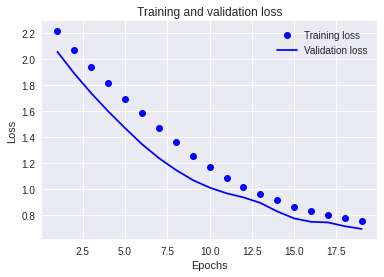

In [142]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Sensitivity analysis (0.5 points)

If you do a theory notebook, program different values for the parameters, use different functional forms and solve your model again for these new values. Show that the outcomes are robust to such changes.

If you are using data, how sensitive are your results to outliers in the data, different choices when cleaning the data, different functional forms for the relations that you estimate.


# Discussion and conclusion (0.5 points)

What did you find in the analysis above; what is the answer to the question you started out with.

What are weaknesses of your approach that can be improved upon in future research (e.g. in your thesis).


# Sources 
